# 17 - Protecao, chaveamento, magneticos e probes

Este notebook cobre os componentes novos de eventos, magneticos e instrumentacao:

- eventos: `fuse`, `circuit_breaker`, `relay`, `thyristor`, `triac`;
- magneticos: `saturable_inductor`, `coupled_inductor`;
- instrumentacao: `voltage_probe`, `current_probe`, `power_probe`, `electrical_scope`, `thermal_scope`;
- dispositivos extras: `BJT_NPN`, `BJT_PNP`, `SNUBBER_RC`.


In [1]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidates = []
for _ in range(6):
    for _rel in (("build-test", "python"), ("build", "python")):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidates.append(candidate)
    _root = _root.parent

_seen = set()
for candidate in _candidates:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)

import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

print(f"Pulsim version: {ps.__version__}")


Pulsim version: 0.3.3


In [2]:
event_circuit = ps.Circuit()

gnd = event_circuit.ground()
n_main = event_circuit.add_node("main")
n_gate_scr = event_circuit.add_node("gate_scr")
n_gate_triac = event_circuit.add_node("gate_triac")
n_coil = event_circuit.add_node("coil")
n_no = event_circuit.add_node("no")
n_nc = event_circuit.add_node("nc")

# Switches controlados pelos componentes de evento
event_circuit.add_switch("F_SW", n_main, gnd, True, 1e3, 1e-9)
event_circuit.add_switch("B_SW", n_main, gnd, True, 1e3, 1e-9)
event_circuit.add_switch("SCR_SW", n_main, gnd, False, 1e3, 1e-9)
event_circuit.add_switch("TRI_SW", n_main, gnd, False, 1e3, 1e-9)
event_circuit.add_switch("K1__no", n_main, n_no, False, 1e3, 1e-9)
event_circuit.add_switch("K1__nc", n_main, n_nc, True, 1e3, 1e-9)

event_circuit.add_virtual_component(
    "fuse",
    "F1",
    [n_main, gnd],
    {"g_on": 1.0, "blow_i2t": 0.012, "initial_closed": 1.0},
    {"target_component": "F_SW"},
)
event_circuit.add_virtual_component(
    "circuit_breaker",
    "B1",
    [n_main, gnd],
    {"g_on": 1.0, "trip_current": 6.0, "trip_time": 80e-6, "initial_closed": 1.0},
    {"target_component": "B_SW"},
)
event_circuit.add_virtual_component(
    "thyristor",
    "SCR1",
    [n_gate_scr, n_main, gnd],
    {"gate_threshold": 1.0, "holding_current": 0.05, "latch_current": 0.10, "g_on": 1.0},
    {"target_component": "SCR_SW"},
)
event_circuit.add_virtual_component(
    "triac",
    "TRI1",
    [n_gate_triac, n_main, gnd],
    {"gate_threshold": 1.0, "holding_current": 0.05, "latch_current": 0.10, "g_on": 1.0},
    {"target_component": "TRI_SW"},
)
event_circuit.add_virtual_component(
    "relay",
    "K1",
    [n_coil, gnd],
    {"pickup_voltage": 5.0, "dropout_voltage": 3.0},
    {"target_component_no": "K1__no", "target_component_nc": "K1__nc"},
)

print("Circuito de eventos pronto.")
print("Virtual components:", event_circuit.virtual_component_names())


Circuito de eventos pronto.
Virtual components: ['F1', 'B1', 'SCR1', 'TRI1', 'K1']


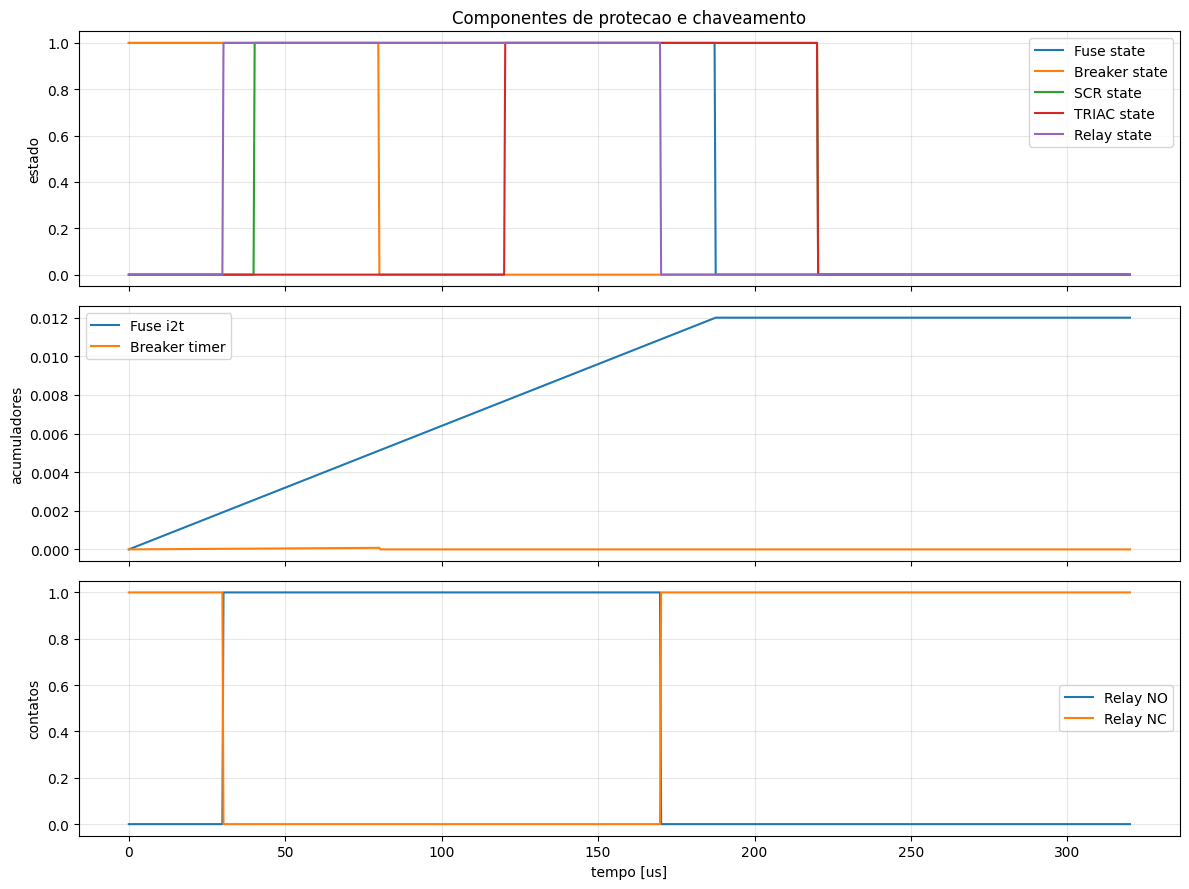

In [3]:
times = np.linspace(0.0, 320e-6, 900)

signals = {
    "F1.state": [],
    "F1.i2t": [],
    "B1.state": [],
    "B1.trip_timer": [],
    "SCR1.state": [],
    "TRI1.state": [],
    "K1.state": [],
    "K1.no_state": [],
    "K1.nc_state": [],
}

for t in times:
    x = np.zeros(event_circuit.system_size())

    # Perfil de tensao principal para estressar fuse/breaker e latch
    x[n_main] = 8.0 if t < 220e-6 else 0.0

    # Pulso de gate para SCR e TRIAC
    x[n_gate_scr] = 2.0 if 40e-6 <= t <= 90e-6 else 0.0
    x[n_gate_triac] = 2.0 if 120e-6 <= t <= 165e-6 else 0.0

    # Excitacao de bobina do rele
    x[n_coil] = 6.0 if 30e-6 <= t <= 170e-6 else 0.0

    step = event_circuit.execute_mixed_domain_step(x, float(t))
    for key in signals:
        signals[key].append(step.channel_values.get(key, np.nan))

us = times * 1e6

fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

ax[0].plot(us, signals["F1.state"], label="Fuse state")
ax[0].plot(us, signals["B1.state"], label="Breaker state")
ax[0].plot(us, signals["SCR1.state"], label="SCR state")
ax[0].plot(us, signals["TRI1.state"], label="TRIAC state")
ax[0].plot(us, signals["K1.state"], label="Relay state")
ax[0].set_ylabel("estado")
ax[0].set_title("Componentes de protecao e chaveamento")
ax[0].legend(loc="best")
ax[0].grid(alpha=0.3)

ax[1].plot(us, signals["F1.i2t"], label="Fuse i2t")
ax[1].plot(us, signals["B1.trip_timer"], label="Breaker timer")
ax[1].set_ylabel("acumuladores")
ax[1].legend(loc="best")
ax[1].grid(alpha=0.3)

ax[2].plot(us, signals["K1.no_state"], label="Relay NO")
ax[2].plot(us, signals["K1.nc_state"], label="Relay NC")
ax[2].set_xlabel("tempo [us]")
ax[2].set_ylabel("contatos")
ax[2].legend(loc="best")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Transient status: True Transient completed


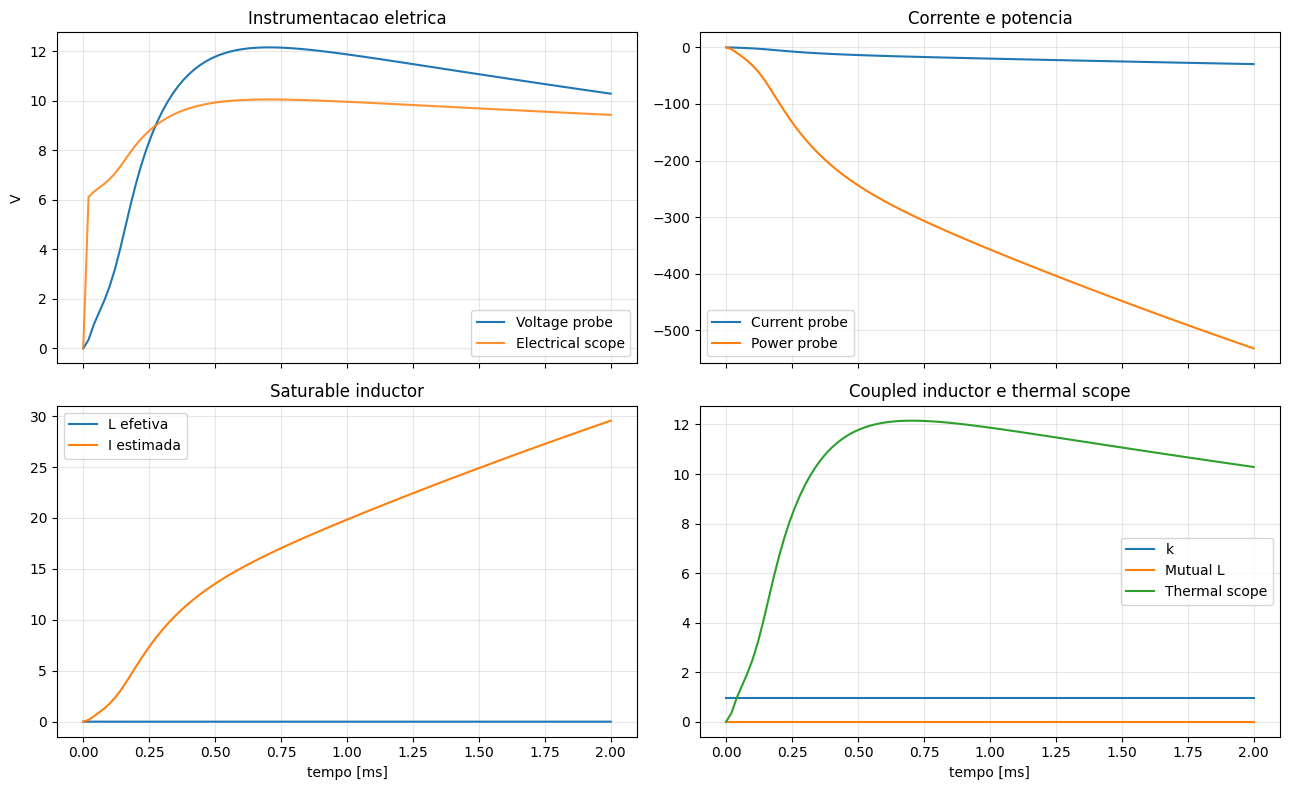

In [4]:
mag = ps.Circuit()

gnd = mag.ground()
n_in = mag.add_node("in")
n_sat = mag.add_node("sat")
n_out = mag.add_node("out")
n_sec = mag.add_node("sec")

mag.add_voltage_source("V1", n_in, gnd, 18.0)
mag.add_resistor("Rsrc", n_in, n_sat, 0.2)
mag.add_inductor("Lsat", n_sat, n_out, 1e-3)
mag.add_resistor("Rload", n_out, gnd, 2.5)
mag.add_inductor("K1__L1", n_out, gnd, 1e-3)
mag.add_inductor("K1__L2", n_sec, gnd, 2e-3)
mag.add_resistor("Rsec", n_sec, gnd, 4.0)
mag.add_snubber_rc("SN1", n_out, gnd, 120.0, 100e-9)

mag.add_virtual_component(
    "saturable_inductor",
    "LSAT1",
    [n_sat, n_out],
    {
        "inductance": 1e-3,
        "saturation_current": 2.0,
        "saturation_inductance": 2e-4,
        "saturation_exponent": 2.5,
    },
    {"target_component": "Lsat"},
)
mag.add_virtual_component(
    "coupled_inductor",
    "K1",
    [n_out, gnd, n_sec, gnd],
    {"l1": 1e-3, "l2": 2e-3, "coupling": 0.95},
    {"target_component_1": "K1__L1", "target_component_2": "K1__L2"},
)
mag.add_virtual_component("voltage_probe", "VP1", [n_out, gnd], {}, {})
mag.add_virtual_component("current_probe", "IP1", [n_in, gnd], {}, {"target_component": "V1"})
mag.add_virtual_component("power_probe", "PP1", [n_in, gnd], {}, {"target_component": "V1"})
mag.add_virtual_component("electrical_scope", "SCOPE_E", [n_in, n_out, gnd], {}, {})
mag.add_virtual_component("thermal_scope", "SCOPE_T", [n_out], {}, {})

x0 = np.zeros(mag.system_size())
newton = ps.NewtonOptions()
newton.max_iterations = 180

t, x, ok, msg = ps.run_transient(mag, 0.0, 2e-3, 2e-5, x0, newton)
print("Transient status:", ok, msg)

assert ok and len(x) > 0, msg

channels = {
    "VP1": [],
    "IP1": [],
    "PP1": [],
    "SCOPE_E": [],
    "SCOPE_T": [],
    "LSAT1.l_eff": [],
    "LSAT1.i_est": [],
    "K1.k": [],
    "K1.mutual": [],
}

for tk, state in zip(t, x):
    step = mag.execute_mixed_domain_step(state, float(tk))
    for key in channels:
        channels[key].append(step.channel_values.get(key, np.nan))

ms = np.array(t) * 1e3
fig, ax = plt.subplots(2, 2, figsize=(13, 8), sharex=True)

ax[0, 0].plot(ms, channels["VP1"], label="Voltage probe")
ax[0, 0].plot(ms, channels["SCOPE_E"], label="Electrical scope", alpha=0.85)
ax[0, 0].set_ylabel("V")
ax[0, 0].set_title("Instrumentacao eletrica")
ax[0, 0].legend(loc="best")
ax[0, 0].grid(alpha=0.3)

ax[0, 1].plot(ms, channels["IP1"], label="Current probe")
ax[0, 1].plot(ms, channels["PP1"], label="Power probe")
ax[0, 1].set_title("Corrente e potencia")
ax[0, 1].legend(loc="best")
ax[0, 1].grid(alpha=0.3)

ax[1, 0].plot(ms, channels["LSAT1.l_eff"], label="L efetiva")
ax[1, 0].plot(ms, channels["LSAT1.i_est"], label="I estimada")
ax[1, 0].set_xlabel("tempo [ms]")
ax[1, 0].set_title("Saturable inductor")
ax[1, 0].legend(loc="best")
ax[1, 0].grid(alpha=0.3)

ax[1, 1].plot(ms, channels["K1.k"], label="k")
ax[1, 1].plot(ms, channels["K1.mutual"], label="Mutual L")
ax[1, 1].plot(ms, channels["SCOPE_T"], label="Thermal scope")
ax[1, 1].set_xlabel("tempo [ms]")
ax[1, 1].set_title("Coupled inductor e thermal scope")
ax[1, 1].legend(loc="best")
ax[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
import textwrap

yaml_bjt = textwrap.dedent(
    """
    schema: pulsim-v1
    version: 1
    simulation:
      tstart: 0
      tstop: 1e-6
      dt: 1e-7
    components:
      - type: voltage_source
        name: V1
        nodes: [in, 0]
        waveform: {type: dc, value: 5}
      - type: resistor
        name: R1
        nodes: [in, out]
        value: 1k
      - type: BJT_NPN
        name: QN1
        nodes: [base, in, out]
        beta: 100
      - type: BJT_PNP
        name: QP1
        nodes: [base, in, out]
        beta: 80
      - type: SNUBBER_RC
        name: SN1
        nodes: [in, out]
        resistance: 100
        capacitance: 100n
    """
).strip()

parser = ps.YamlParser()
c_bjt, _ = parser.load_string(yaml_bjt)

print("BJT + snubber YAML status:", "OK" if not parser.errors else "ERRO")
if parser.errors:
    print(parser.errors)
else:
    print("Devices:", c_bjt.num_devices(), "| Virtual:", c_bjt.num_virtual_components())
    print("Node names:", c_bjt.node_names())


BJT + snubber YAML status: OK
Devices: 6 | Virtual: 0
Node names: ['in', 'out', 'base']
